In [17]:
import matplotlib.pyplot as plt
from models import VAE_CNN

import seaborn as sns
import numpy as np
import torch
import os
from skimage import io, transform
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from skimage.io import imread
from torchsummary import summary
import pandas as pd
import time

import argparse


parser = argparse.ArgumentParser(description='Arguments for VAE')

parser.add_argument('PRE_TRAINED', action="store")
parser.add_argument('NAME', action="store")

parser.add_argument('LYR_ENC', action="store")
parser.add_argument('LYR_DEC', action="store")
parser.add_argument('KL_PAR', action="store", type=float)
parser.add_argument('EPOCHS', action="store", type=int)

print(parser.parse_args())
read = parser.parse_args()

PRE_TRAINED = read.PRE_TRAINED 
NAME_AUX = read.NAME 
LYR_ENC = read.LYR_ENC
LYR_DEC = read.LYR_DEC
KL_PAR = read.KL_PAR
EPOCHS = int(read.EPOCHS)

NAME = NAME_AUX + '-' + LYR_ENC + '-' + LYR_DEC

'''
PRE_TRAINED = '../models/KL3z'
NAME = 'KL3z'

LYR_ENC = '0006'
LYR_DEC = '0000'
KL_PAR = 0.0001
EPOCHS = 4*4
'''

SAVE_RESULTS = '../results/results-portinari/' + NAME
print(SAVE_RESULTS)

LYR_ENC_START = int(LYR_ENC[0]+LYR_ENC[1])
LYR_ENC_END = int(LYR_ENC[2]+LYR_ENC[3])
LYR_DEC_START = int(LYR_DEC[0]+LYR_DEC[1])
LYR_DEC_END = int(LYR_DEC[2]+LYR_DEC[3])

BATCH_SIZE = 32
LOG_INTERVAL = 30
BOTTLENECK_SIZE = 512


TRAIN_ROOT = '../data/data-portinari/Train/'
VAL_ROOT = '../data/data-portinari/Validation/'
TRAIN_ROOT_FIX = '../data/data-portinari/Fix_sample_train/'
VAL_ROOT_FIX = '../data/data-portinari/Fix_sample_validation/'
TRAIN_ROOT_CELEBA_FIX = '../data/data-celeba/Fix_sample/'

%mkdir {SAVE_RESULTS}

mkdir: cannot create directory ‘../results/results-portinari/KL3z’: File exists


In [18]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [19]:
no_cuda = False
seed = 1
cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
torch.manual_seed(seed)

transform_seq = [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
transform_seq_celeba = [ transforms.Resize((200,163)), transforms.Pad(( 19, 0, 18, 0)),
                  transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]


train_loader_portinari = torch.utils.data.DataLoader(
    datasets.ImageFolder(TRAIN_ROOT, transform=transforms.Compose(transform_seq)),
    drop_last = False, batch_size = BATCH_SIZE, shuffle=True, **kwargs)
    
train_loader_portinari.dataset.samples = 10*train_loader_portinari.dataset.samples

val_loader_portinari = torch.utils.data.DataLoader(
    datasets.ImageFolder(VAL_ROOT, transform=transforms.Compose(transform_seq)), 
    drop_last = False, batch_size = BATCH_SIZE, shuffle=True, **kwargs)

train_loader_portinari_fix = torch.utils.data.DataLoader(
    datasets.ImageFolder(TRAIN_ROOT_FIX, transform=transforms.Compose(transform_seq)),
    drop_last = False, batch_size = 10, shuffle=False, **kwargs)

val_loader_portinari_fix = torch.utils.data.DataLoader(
    datasets.ImageFolder(VAL_ROOT_FIX, transform=transforms.Compose(transform_seq)), 
    drop_last = False, batch_size = 10, shuffle=False, **kwargs)

train_loader_celeba_fix = torch.utils.data.DataLoader(
    datasets.ImageFolder(TRAIN_ROOT_CELEBA_FIX, transform=transforms.Compose(transform_seq_celeba)), 
    drop_last = False, batch_size = 10, shuffle=False, **kwargs)


In [20]:
sample_val = [('../data/data-portinari/Validation/colour/5352.jpg', 0),
 ('../data/data-portinari/Validation/colour/4027.jpg', 0),
 ('../data/data-portinari/Validation/colour/3679.jpg', 0),
 ('../data/data-portinari/Validation/colour/3684.jpg', 0),
 ('../data/data-portinari/Validation/colour/4143.jpg', 0),
 ('../data/data-portinari/Validation/colour/5168.jpg', 0),
 ('../data/data-portinari/Validation/colour/4008.jpg', 0)]
#sample_val = np.random.choice([i[0] for i in val_loader_portinari.dataset.samples], size = 7, replace = False)
#val_loader_portinari_fix.dataset.samples = [(i, 0) for i in sample_val]
#val_loader_portinari_fix.dataset.samples
val_loader_portinari_fix.dataset.samples = sample_val
val_loader_portinari_fix.dataset.samples

[('../data/data-portinari/Validation/colour/5352.jpg', 0),
 ('../data/data-portinari/Validation/colour/4027.jpg', 0),
 ('../data/data-portinari/Validation/colour/3679.jpg', 0),
 ('../data/data-portinari/Validation/colour/3684.jpg', 0),
 ('../data/data-portinari/Validation/colour/4143.jpg', 0),
 ('../data/data-portinari/Validation/colour/5168.jpg', 0),
 ('../data/data-portinari/Validation/colour/4008.jpg', 0)]

In [21]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="mean")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = -1)
        loss_KLD = torch.sum(loss_KLD*KL_PAR)/BATCH_SIZE
        return loss_MSE, loss_KLD

In [22]:
model = VAE_CNN(BOTTLENECK_SIZE).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha= 0.9)
loss_custom = customLoss()

In [40]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline
def show(img, save_path):
    npimg = img.detach().numpy()
    plt.figure(figsize=(30, 10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.imsave(save_path, np.transpose(npimg, (1,2,0)))

In [24]:
checkpoint = torch.load(PRE_TRAINED)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


<All keys matched successfully>

In [25]:
layers = []
for ly in model.named_children():
    layers.append(ly)
i = 0 
'''
for ly in layers:
    print(i, ly)
    i = i +1   
parameters= []

for i in [0, 6,9, 12, 19, 25]:
    parameters.append((i, layers[i][1].bias.cpu().detach().numpy()))'''

'\nfor ly in layers:\n    print(i, ly)\n    i = i +1   \nparameters= []\n\nfor i in [0, 6,9, 12, 19, 25]:\n    parameters.append((i, layers[i][1].bias.cpu().detach().numpy()))'

In [26]:

for i in range(0, 32):
    layers[i][1].requires_grad_(True)

print("Frozen layers - encoder:\n")
for i in range(LYR_ENC_START, LYR_ENC_END):
    layers[i][1].requires_grad_(False)
    print(i, layers[i][1])
print("\nFrozen layers - decoder:\n")
for i in range(LYR_DEC_START, LYR_DEC_END):
    layers[i][1].requires_grad_(False)
    print(i, layers[i][1])

Frozen layers - encoder:

0 Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
3 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
5 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

Frozen layers - decoder:



In [27]:
'''layers = []

for child in model.named_children():
    child[1].requires_grad_(True)
    print(child)
    for name, par in child[1].named_parameters():
        print(name)
    
model.conv3.bias'''

'layers = []\n\nfor child in model.named_children():\n    child[1].requires_grad_(True)\n    print(child)\n    for name, par in child[1].named_parameters():\n        print(name)\n    \nmodel.conv3.bias'

In [28]:
'''for batch_idx, (data, _) in enumerate(tr):
    show(make_grid(data.cpu(), nrow=10, normalize=True))'''

'for batch_idx, (data, _) in enumerate(tr):\n    show(make_grid(data.cpu(), nrow=10, normalize=True))'

In [4]:
train_losses = []

def train(epoch):
    interval_counter = 0
    model.train()
    acc_loss_MSE = 0
    acc_loss_KL = 0
    
    start = time.time()
    #print('\n')
    for batch_idx, (data, _) in enumerate(train_loader_portinari): 
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
        loss = loss_mse + loss_kl
        loss.backward()
        acc_loss_MSE += loss_mse.item()
        acc_loss_KL += loss_kl.item() 
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            interval = time.time() - start
            start = time.time()
            interval_counter += interval
            train_losses.append((loss_mse.item(), loss_kl.item())) 
            '''
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss MSE: {:.6f} \tLoss KL: {:.6f} \t Interval: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_portinari.dataset),
                       100. * batch_idx / len(train_loader_portinari),
                       loss_mse.item(), loss_kl.item(), interval))'''
            
    print("End of EPOCH : {}, Elapsed time : {:.4f}".format(epoch, interval_counter))
    print(color.BOLD + '====> Train set LOSS MSE: {:.6f}, LOSS KL: {:.6f}'.format(
        acc_loss_MSE * BATCH_SIZE/ len(train_loader_portinari.dataset), 
        acc_loss_KL * BATCH_SIZE /  len(train_loader_portinari.dataset)) + color.END)
    #train_losses.append(train_loss*BATCH_SIZE/ len(train_loader_portinari.dataset))

In [2]:
val_losses = []

def test(epoch, sufix, train):
    model.train(train)
    test_loss_mse = 0
    test_loss_kl = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader_portinari):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
            loss = loss_mse + loss_kl
            test_loss_mse += loss_mse.item()
            test_loss_kl += loss_kl.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(BATCH_SIZE, 3, 200, 200)[:n]])
                save_image(comparison.cpu(),
                           SAVE_RESULTS + '/reconstruction_' + str(epoch) + sufix + '.png', nrow=n, normalize=True)

    test_loss_mse = test_loss_mse * BATCH_SIZE / len(val_loader_portinari.dataset)
    test_loss_kl = test_loss_kl * BATCH_SIZE / len(val_loader_portinari.dataset)
    print(color.BOLD + '====> Test set  LOSS MSE: {:.6f}, LOSS KL: {:.6f}'.format(test_loss_mse, test_loss_kl)
          + color.END)
    val_losses.append((test_loss_mse, test_loss_kl))

In [3]:
def reconstruction_hist(loader, epoch, imgs_conc):
    
    model.train(False)
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(loader):
            
            if epoch == 1:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                n = min(data.size(0), 7)
                #print('entrou1')
                imgs_conc = torch.cat([data[:n],
                                        recon_batch.view(7, 3, 200, 200)[:n]])
                
            elif (epoch % 4) == 1: 
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                #print('entrou')
                n = min(data.size(0), 7)
                imgs_conc = torch.cat([imgs_conc,
                                        recon_batch.view(7, 3, 200, 200)[:n]])
    return imgs_conc

In [32]:
imgs_train_fix = []
imgs_val_fix = []
imgs_train_celeba_fix = []


for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch, '', False)
    #test(epoch, '_off', False)
    imgs_train_fix = reconstruction_hist(train_loader_portinari_fix, epoch, imgs_train_fix)
    imgs_val_fix = reconstruction_hist(val_loader_portinari_fix, epoch, imgs_val_fix)
    imgs_train_celeba_fix = reconstruction_hist(train_loader_celeba_fix, epoch, imgs_train_celeba_fix)
    with torch.no_grad():
        model.train(False)
        sample = torch.randn(BATCH_SIZE, BOTTLENECK_SIZE).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(BATCH_SIZE, 3, 200, 200),
                   SAVE_RESULTS + '/sample_' + str(epoch) + '_off_' 
                    + '.png', normalize=True)
        
np.save(SAVE_RESULTS + '/val_losses', val_losses)
np.save(SAVE_RESULTS + '/train_losses', train_losses)



Train Epoch: 1 [0/3050 (0%)]	Loss MSE: 0.125457 	Loss KL: 0.015668 	 Interval: 0.245533
Train Epoch: 1 [960/3050 (31%)]	Loss MSE: 0.047673 	Loss KL: 0.015874 	 Interval: 5.250010
Train Epoch: 1 [1920/3050 (62%)]	Loss MSE: 0.040660 	Loss KL: 0.015929 	 Interval: 5.226823
Train Epoch: 1 [2880/3050 (94%)]	Loss MSE: 0.040317 	Loss KL: 0.015938 	 Interval: 5.272490
====> Epoch: 1 Average loss: 0.0672 Elapsed Time: 15.994857
====> Test set LOSS MSE: 0.058604, loss-kl: 0.016633


Train Epoch: 2 [0/3050 (0%)]	Loss MSE: 0.041465 	Loss KL: 0.015965 	 Interval: 0.239613
Train Epoch: 2 [960/3050 (31%)]	Loss MSE: 0.034824 	Loss KL: 0.015918 	 Interval: 5.223353
Train Epoch: 2 [1920/3050 (62%)]	Loss MSE: 0.033957 	Loss KL: 0.015823 	 Interval: 5.282440
Train Epoch: 2 [2880/3050 (94%)]	Loss MSE: 0.035498 	Loss KL: 0.015722 	 Interval: 5.260099
====> Epoch: 2 Average loss: 0.0549 Elapsed Time: 16.005506
====> Test set LOSS MSE: 0.061134, loss-kl: 0.016596


Train Epoch: 3 [0/3050 (0%)]	Loss MSE: 0.0

KeyboardInterrupt: 

In [ ]:
'''layers_after = []
for ly in model.named_children():
    layers_after.append(ly)
i = 0 
for ly in layers_after:
    print(i, ly)
    i = i +1


parameters_after= []

for i in [0, 6,9, 12, 19, 25]:
    parameters_after.append((i, layers_after[i][1].bias.cpu().detach().numpy()))'''

In [42]:
make_grid(imgs_train_celeba_fix.cpu(), nrow=7, normalize=True)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0003,  ..., 0.0052, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0010,  ..., 0.0137, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

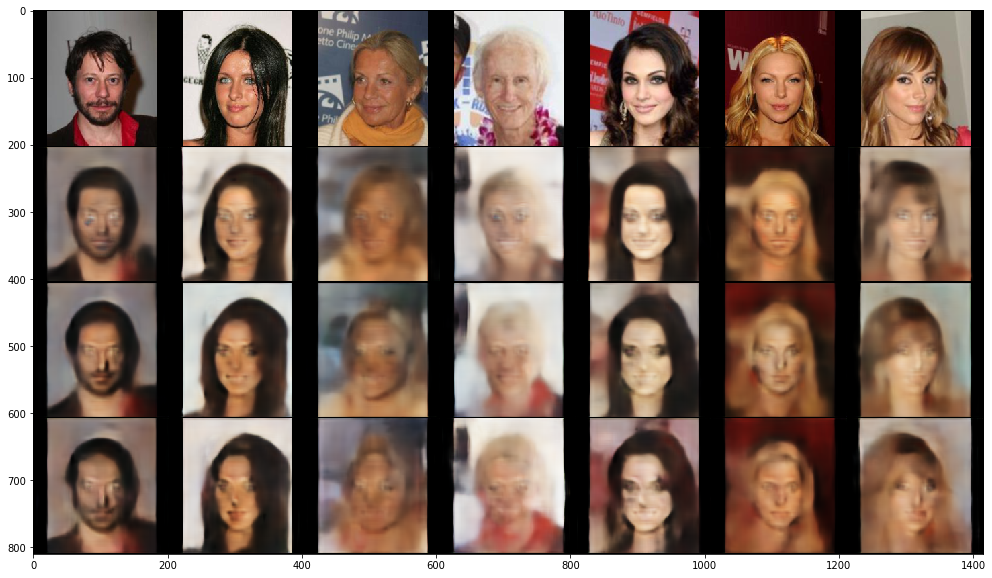

In [43]:
show(make_grid(imgs_train_celeba_fix.cpu(), nrow=7, normalize=True), SAVE_RESULTS + '/celeba_evolution.jpg')

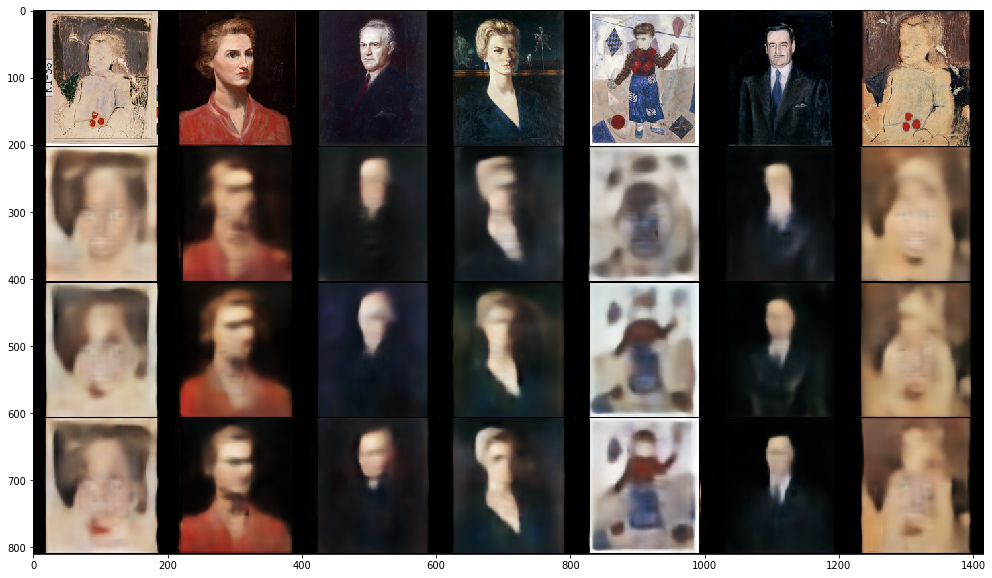

In [44]:
show(make_grid(imgs_train_fix.cpu(), nrow=7, normalize=True), SAVE_RESULTS + '/portinari_train_evolution.jpg')

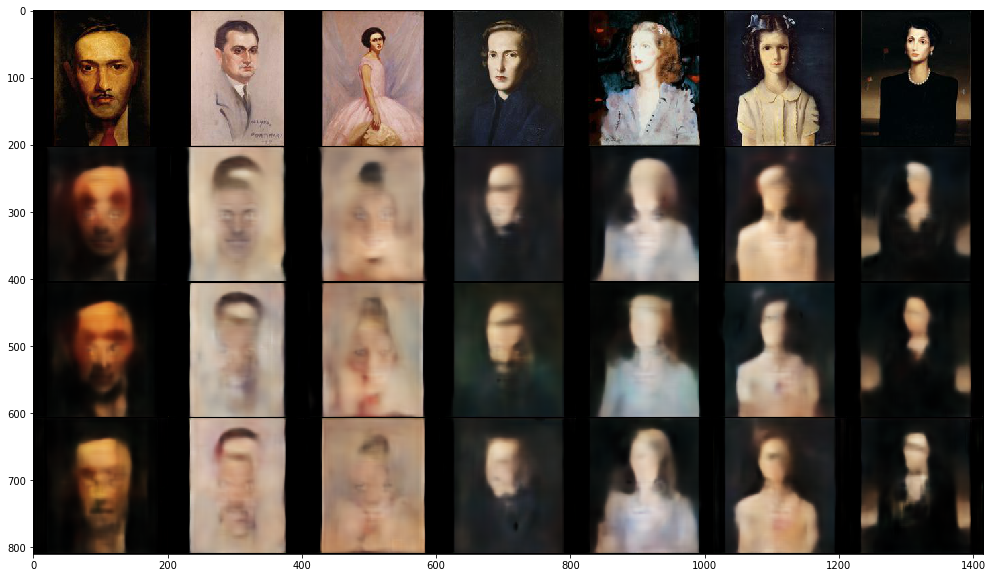

In [45]:
show(make_grid(imgs_val_fix.cpu(), nrow=7, normalize=True), SAVE_RESULTS + '/portinari_val_evolution.jpg')